<a href="https://github.com/linogaliana/python-datascientist/blob/master/course/NLP/05_exo_supp.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/course/NLP/05_exo_supp.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/course/NLP/05_exo_supp.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABcour
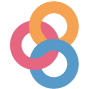

In [1]:
#| echo: false
#| output: 'asis'
#| include: true
#| eval: true

import sys
sys.path.insert(1, '../../../../') #insert the utils module
from utils import print_badges

#print_badges(__file__)
print_badges("content/course/NLP/05_exo_supp.qmd")

Cette page approfondit certains aspects présentés dans les autres tutoriels. Il s'agit d'une suite d'exercice, avec corrections, pour présenter d'autres aspects du NLP ou pratiquer sur des données différentes


# Exploration des libellés de l'openfood database

{{% box status="exercise" title="Exercise: les noms de produits dans l'openfood database" icon="fas fa-pencil-alt" %}}
L'objectif de cet exercice est d'analyser les termes les plus fréquents
dans les noms de produits de l'openfood database. Au passage, cela permet de réviser les étapes de *preprocessing* (LIEN XXXXX) et d'explorer les enjeux de reconnaissance d'entités nommées. 
{{% /box %}}

Dans cet exercice:

* tokenisation (`nltk`)
* retrait des stop words (`nltk`)
* nuage de mots (`wordcloud`)
* reconnaissance du langage (`fasttext`)
* reconnaissance d'entités nommées (`spacy`)

le tout sur l'OpenFood Database, une base de données alimentaire qui est enrichie de manière collaborative. 

{{% box status="hint" title="Hint" icon="fa fa-lightbulb" %}}
Pour pouvoir utiliser les modèles pré-entraînés de `spaCy`, il faut les télécharger. La méthode préconisée est d'utiliser, depuis un terminal, la commande suivante

```python
python -m spacy download fr_core_news_sm
```

Dans un notebook jupyter, il se peut qu'il soit nécessaire de relancer le kernel.

Si l'accès à la ligne de commande n'est pas possible, ou si la commande échoue, il est possible de télécharger le modèle pré-entraîné directement depuis une session `Python`

```python
import spacy
spacy.cli.download('fr_core_news_sm')
```

{{% /box %}}


1. Importer le modèle de reconnaissance de langage qui sera utilisé par la suite
ainsi que le corpus Français utilisé par `spacy`


In [2]:
#| output: hide
import tempfile
import os
import spacy

temp_dir = tempfile.NamedTemporaryFile()
temp_dir = temp_dir.name

os.system("wget -O {} https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin".format( "%s.model.bin" % temp_dir))
spacy.cli.download('fr_core_news_sm')

2. Importer les données de l'[openfood database](https://fr.openfoodfacts.org/data) à partir du code suivant


In [3]:
import pandas as pd
import urllib.request


urllib.request.urlretrieve('https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv', "%s.openfood.csv" % temp_dir)
df_openfood = pd.read_csv("%s.openfood.csv" % temp_dir, delimiter="\t",
                          usecols=['product_name'], encoding = 'utf-8', dtype = "str")

Ces données devraient avoir l'aspect suivant:


In [4]:
df_openfood.iloc[:2, :5]

3. Créer une fonction de nettoyage des noms de produits effectuant les 
étapes suivantes:

* tokeniser le texte en question
* retirer la ponctuation et les _stopwords_

Appliquer cette fonction à l'ensemble des noms de produits (variable
`product_name`)


In [5]:
#| echo: false
#| output: hide
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('french'))

def clean_labels_additional(data, yvar = 'product_name'):
    outvar = 'tokenized'
    data[outvar] = data[yvar].astype(str).apply(lambda s: nltk.word_tokenize(s.lower()))
    data[outvar] = data[outvar].apply(lambda words: [word for word in words if word.isalpha()])
    data[outvar] = data[outvar].apply(lambda words: [w for w in words if not w in stop_words])
    data[outvar] = data[outvar].apply(lambda s:  ' '.join(s))
    return data
  
df_openfood = clean_labels_additional(df_openfood)

4. Effectuer un nuage de mot sur les libellés avant et après nettoyage
pour comprendre la structure du corpus en question.
Le résultat devrait avoir l'apparence suivante


In [6]:
import wordcloud as wc
import matplotlib.pyplot as plt


def graph_wordcloud(data, by = None, valueby = None, yvar = "Text"):
    if (by is not None) & (valueby is not None):        
        txt = data[data[by]==valueby][yvar].astype(str)
    else:
        txt = data[yvar].astype(str)
    all_text = ' '.join([text for text in txt])
    wordcloud = wc.WordCloud(width=800, height=500,
                          random_state=21,
                      max_words=2000).generate(all_text)
    return wordcloud

def graph_wordcloud_by(data, by, yvar = "Text"):
    n_topics = data[by].unique().tolist()
    width=20
    height=80
    rows = len(n_topics)//2
    cols = 2
    fig=plt.figure(figsize=(width, height))
    axes = []
    for i in range(cols*rows):
        b = graph_wordcloud(data, by = by, valueby = n_topics[i], yvar = yvar)
        axes.append( fig.add_subplot(rows, cols, i+1) )
        axes[-1].set_title("{}".format(n_topics[i]))  
        plt.imshow(b)
        plt.axis('off')
        plt.savefig('{}.png'.format(yvar), bbox_inches='tight')


def wordcount_words(data, yvar, by = None):
    plt.figure( figsize=(15,15) )
    if by is None:
        wordcloud = graph_wordcloud(data, yvar = yvar, by = by)
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.savefig('{}.png'.format(yvar), bbox_inches='tight')
    else:
        graph_wordcloud_by(data, by = by, yvar = yvar)

wordcount_words(df_openfood, yvar = "product_name")
wordcount_words(df_openfood, "tokenized")

5. Utiliser la librairie `Fasttext` pour extraire les noms de produits
français

* Appliquer le modèle téléchargé précedemment pour déterminer le langage
* Ne récupérer que les libellés français


In [7]:
import fasttext

PRETRAINED_MODEL_PATH = "%s.model.bin" % temp_dir
model = fasttext.load_model(PRETRAINED_MODEL_PATH)
newcols = ['language','score_language']
df_openfood[newcols] = pd.DataFrame(df_openfood['product_name'].astype(str).apply(lambda s: list(model.predict(s))).apply(lambda l: [l[0][0],l[1][0]]).tolist(), columns = newcols)
df_openfood['language'] = df_openfood['language'].str.replace("__label__","")
df_openfood_french = df_openfood[df_openfood['language'] == "fr"]
df_openfood_french.head(2)

6. Visualiser avec `spacy.displacy` le résultat d'une reconnaissance
d'entités nommées sur 50 données aléatoires. Cela vous semble-t-il satisfaisant ?


In [8]:
import spacy
import fr_core_news_sm

nlp = fr_core_news_sm.load()

example = " \n ".join(df_openfood_french['product_name'].astype("str").sample(50))

from spacy import displacy
html = displacy.render(nlp(example), style='ent', page=True)

In [9]:
print(html)

7. Récupérer dans un vecteur les entités nommées reconnues par `spaCy`.
Regarder les entités reconnues dans les 20 premiers libellés de produits 


In [10]:
x = []
for doc in nlp.pipe(df_openfood_french.head(20)['product_name'].astype("unicode"), disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
    # Do something with the doc here
    x.append([(ent.text, ent.label_) for ent in doc.ents])
    
x

<!----
# State of the union address


Un exercice à venir sur l'analyse des discours des présidents américains 
inspiré de https://github.com/BuzzFeedNews/2018-01-trump-state-of-the-union
---->